<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

# Load Keras-TF model and check predictions

The goal of this notebook is to load a saved Keras model created by the TF script, then to process a raw Aquaplanet file and get predictions. Finally, we would like to compare the predictions to the target output.

Little primer on Jupyter notebooks: Ctrl + Enter will execute a cell.

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import netCDF4 as nc
import h5netcdf as h5py
from dataLoad import *
from config import *
from utils import *
import subprocess
import os
import math
import json
import logging
import numpy as np
from PIL import Image
from datetime import datetime
from folderDefs import *
import configargparse
config = tf.ConfigProto()
config.gpu_options.allow_growth = True   # Allocates as much memory as needed.
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load the latest model and the corresponding mean and standard deviation files.

Define the paths where the model and the mean and std files are stored. For me its all the same directory, so you might have to adapt.

In [2]:
model_dir = './logs/0216_114446_SPDT,SPDQ_layers_1024,1024_lr_0.00025_ac_leakyrelu_conv_False_locconv_False_vars_TAP,QAP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic_batchs_1024_loss_RMSE'

In [3]:
model_fn = '/saved_keras_model_5000.h5'

In [4]:
mean_file = './mean_nolat.nc'
std_file = './std_nolat.nc'

In [5]:
model = keras.models.load_model(model_dir + model_fn, custom_objects={"tf": tf})

/anaconda3/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_1 (Activation)    (None, 7, 30, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 210)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              216064    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 60)                61500     
__________

So here is the model which takes 9 input variables with 21 levels each and returns two output variables. In-between we have two fully connected layers with leaky ReLU activations.

In [7]:
# Set number of levels for all functions below!
nlev = 30

In [8]:
mean = nc.Dataset( mean_file)
std = nc.Dataset(std_file)

In [9]:
mean

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): level(30), lats(1), lon(1)
    variables(dimensions): float32 QAP(level,lats,lon), float32 TAP(level,lats,lon), float32 QBP(level,lats,lon), float32 TBP(level,lats,lon), float32 dTdt_adiabatic(level,lats,lon), float32 dQdt_adiabatic(level,lats,lon), float32 SPDT(level,lats,lon), float32 SPDQ(level,lats,lon), float32 TPHYSTND_NORAD(level,lats,lon), float32 PHQ(level,lats,lon), float32 SHFLX(lats,lon), float32 LHFLX(lats,lon), float32 PS(), float32 lat(), float32 SOLIN()
    groups: 

The mean and standard deviation variables have 3 dimensions, but lat and lon only have size 1.

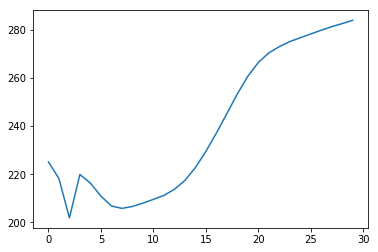

In [10]:
plt.plot(mean['TAP'][-nlev:, 0, 0])

## Load an Aquaplanet file and process as input for NN

These files have been preprocessed with the matlab script to compute derived variables

In [11]:
#data_dir = '/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old/'
#aqua_fn = 'AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-05-00000.nc'
data_dir = '/Users/gentine/Dropbox/Collaborations_Projects/CONN/SP-CAM/Pritchard_Aquaplanet/'   # New file directly from Pierre!
aqua_fn = 'AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc'  # Just randomly grab a file

In [12]:
aqua = nc.Dataset(data_dir + aqua_fn)

In [13]:
aqua

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    source: CAM
    case: AndKua_aqua_SPCAM3.0
    title: 
    logname: tg802402
    host: 
    Version: $Name:  $
    revision_Id: $Id: history.F90,v 1.26.2.38 2003/12/15 18:52:35 hender Exp $
    history: Tue Feb  6 09:26:27 2018: /anaconda3/bin/ncks -x -v TPHYSTND_NORAD --overwrite --output=./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc ./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc
Tue Feb  6 09:26:26 2018: /anaconda3/bin/ncks -x -v QBP --overwrite --output=./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc ./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc
Tue Feb  6 09:26:24 2018: /anaconda3/bin/ncks -x -v TBP --overwrite --output=./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc ./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.n

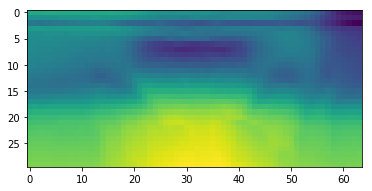

In [14]:
# Let's plot one input and one output variable
plt.imshow(aqua['TAP'][-1, :, :, 0]);

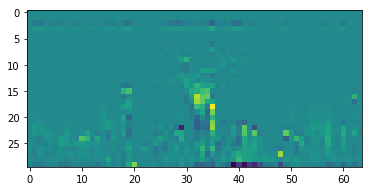

In [15]:
plt.imshow(aqua['SPDT'][-1, :, :, 0]);

Now define the input and output variables. They need to be in the right order!

In [16]:
# TBP,QBP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic
#inps = ['TBP','QBP','PS','SHFLX','LHFLX','dTdt_adiabatic','dQdt_adiabatic']
inps = ['TAP','QAP','PS','SHFLX','LHFLX','dTdt_adiabatic','dQdt_adiabatic']

In [17]:
outps = ['SPDT','SPDQ']

The following script takes each variable, normalizes it by subtracting the mean and dividing by the standard deviation. Then the 2D variables (PS) are tiled to fill the 30 levels. We do this for the input and output array.

Note that additionally the vertical axis is flipped.

In [18]:
def convert_ds(ds, vars, normalize=True, flip_vertical=True):
    """Convert to [sample, feature, lev, 1]"""
    arr = []
    for var in vars:
        da = ds[var][:]
        m = mean[var][:]; s = std[var][:]
        if normalize: da = (da - m) / s   # Pierre is normalizing both inputs and outputs. Is that right?
        if da.ndim == 4:   # 3D variables [time, lev, lat, lon] --> [sample, lev]
            a = np.rollaxis(da, 1, 4).reshape(-1, 30)
        elif da.ndim == 3:   # 2D variables [time, lat, lon]
            a = np.rollaxis(np.tile(da.reshape(-1), (30, 1)), 0, 2)
        elif da.ndim == 1:   # lat
            a = np.rollaxis(np.tile(da, (48, 30, 128, 1)), 1, 4).reshape(-1, 30)
        else:
            raise Exception('Incompatible number of dimensions')
        arr.append(a)
    arr = np.expand_dims(np.rollaxis(np.array(arr), 0, 2), 3) # [sample, feature, lev, 1]
    arr = arr[:, :, -nlev:]
    if flip_vertical: arr = arr[:, :, ::-1]   # I think this should be true for inputs and outputs
    return arr

In [19]:
# First check whether we did the transformations correct by looking at the 
# non-normalized output
inp_arr_nonnorm = convert_ds(aqua, inps, normalize=False)


In [20]:
inp_arr_nonnorm.shape   # [sample, feature, lev, 1]

(393216, 7, 30, 1)

In [21]:
def unravel(x):
    """Convert back from [sample] to [time, lat, lon]"""
    return x.reshape(48, 64, 128, -1, nlev)

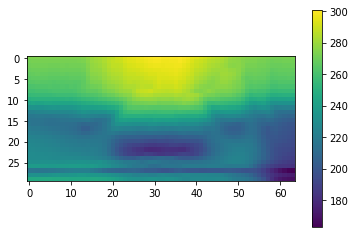

In [22]:
plt.imshow(unravel(inp_arr_nonnorm)[-1, :, 0, 0, :].T); # Vertical axis is flipped.
plt.colorbar();

In [32]:
folderPath = '../SP-CAM/Pritchard_Aquaplanet/'
rawFileBase= 'AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-01-00001.nc'
config = load_config(model_dir, subset=None)
a = DataLoader(folderPath, config, rawFileBase)

[read] PARAM path: ./logs/0216_114446_SPDT,SPDQ_layers_1024,1024_lr_0.00025_ac_leakyrelu_conv_False_locconv_False_vars_TAP,QAP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic_batchs_1024_loss_RMSE/params.json
self.varAllList ['TAP', 'QAP', 'PS', 'SHFLX', 'LHFLX', 'dTdt_adiabatic', 'dQdt_adiabatic', 'SPDT', 'SPDQ']
./mean_nolat.nc
./std_nolat.nc
 raw_data_train_path ../SP-CAM/Pritchard_Aquaplanet/*.nc 
['0000-01-01-00000', '0000-01-02-00000', '0000-01-03-00000']
last raw file: ../SP-CAM/Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-30-00000.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    source: CAM
    case: AndKua_aqua_SPCAM3.0
    title: 
    logname: tg802402
    host: 
    Version: $Name:  $
    revision_Id: $Id: history.F90,v 1.26.2.38 2003/12/15 18:52:35 hender Exp $
    history: Tue Feb  6 09:23:17 2018: /anaconda3/bin/ncks -x -v TPHYSTND_NORAD --overwrite --output=./Pritchard_Aquaplanet/And

NameError: name 'kfileReader' is not defined

In [24]:
# Now check out the normalized output
inp_arr = convert_ds(aqua, inps)

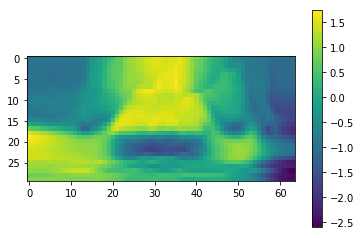

In [25]:
plt.imshow(unravel(inp_arr)[-1, :, 0, 0, :].T); # Vertical axis is flipped.
plt.colorbar();

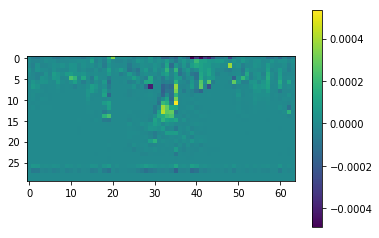

In [26]:
# Check the non-normalized version of the output array
plt.imshow(unravel(convert_ds(aqua, outps, normalize=False))[-1, :, 0, 0, :].T); # Vertical axis is flipped.
plt.colorbar();

In [27]:
# Now also normalize the output array
outp_arr = convert_ds(aqua, outps)

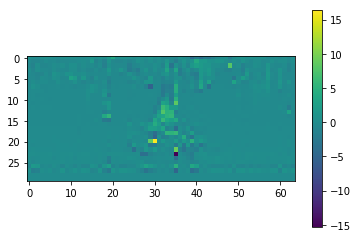

In [28]:
plt.imshow(unravel(outp_arr)[-1, :, 0, 0, :].T); # Vertical axis is flipped.
plt.colorbar();

In [35]:
print(fileReader)
aqua_rg = nc.Dataset(fileReader, mode='r')
print(aqua_rg)

../SP-CAM/Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-01-00001.nc


FileNotFoundError: [Errno 2] No such file or directory: b'../SP-CAM/Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-01-00001.nc'

In [ ]:
def accessTimeData(self, fileReader, names, iTim, doLog=False):
    inputs = []
    aqua_rg = nc.Dataset(fileReader, mode='r')
    
    for k in aqua_rg.variables.keys():
        self.varDim[k] = len(aqua_rg[k].shape)
        
    for k in names:
        if doLog: 
            print('accessTimeData', 'varDim[k]=', self.varDim[k], 'fileReader[k]=', fileReader[k].shape)
        if self.varDim[k] == 4: 
            arr = fileReader[k][iTim]
        elif self.varDim[k] == 3:
            arr = fileReader[k][iTim][None]
        elif self.varDim[k] == 2:
            arr = fileReader[k][None] 
        elif self.varDim[k] == 1: # latitude only
            # need to transform in single as latitude is in double
            arr = fileReader[k]
            arr = np.swapaxes(np.tile(arr, (1,self.n_lon,1)),1,2)# repeat lat to trasnform into matrix
            arr = arr.astype('float32') # impose float 32 like other varaiables
        if doLog: 
            print(k, '----> arr=', arr.shape)
        # noamlize data firs, better for convergences
        if self.config.normalizeInoutputs:
            arr = self.normalizeInoutputs(k, arr)
        else: # does not allow double nmormalizations
            if self.config.convert_units:
                arr = self.convertUnits(k, arr)
        if self.varDim[k] == 4: # only keep n top pressure levels        
            arr = arr[(arr.shape[0]-self.n_lev):(arr.shape[0]),:,:] # select just n levels
        if doLog: 
            print(k, '--------> arr=', arr.shape)
        if arr.shape[0] == 1:
            arr = np.tile(arr, (self.n_lev,1,1))
        if doLog: 
            print(k, '------------> arr=', arr.shape)
        inputs += [arr]

    inX = np.stack(inputs, axis=0)
    if doLog: 
        print('accessTimeData ', names, inX.shape)
    return inX


## Get model predictions

We will now use the normalized input array and check out the predictions

In [28]:
inp_arr.shape

NameError: name 'inp_arr' is not defined

In [28]:
preds = model.predict(inp_arr, batch_size=1024)

NameError: name 'inp_arr' is not defined

In [206]:
preds.shape, outp_arr.shape

((393216, 2, 30, 1), (393216, 2, 30, 1))

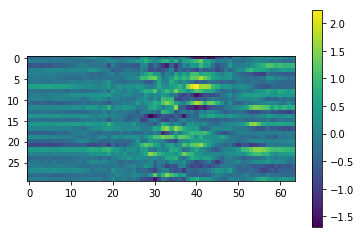

In [207]:
# First, check the raw predictions which should match the normalized outputs
plt.imshow(unravel(preds)[-1, :, 0, 0, :].T); # Vertical axis is flipped.
plt.colorbar();

In [208]:
def denorm(arr, vars):
    # Inputs [sample, feature, lev, 1]
    a = np.copy(arr)
    a = a.reshape(48, 64, 128, -1, nlev)  # [time, lat, lon, feature, lev]
    for i, var in enumerate(vars):
        m = np.rollaxis(mean[var][-nlev:][::-1], 0, 3) 
        s = np.rollaxis(std[var][-nlev:][::-1], 0, 3) 
        a[:, :, :, i, :] = a[:, :, :, i, :] * s + m
    return a

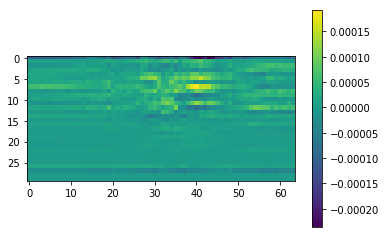

In [209]:
# Try to denormalize the predictions
plt.imshow(denorm(unravel(preds), outps)[-1, :, 0, 0, :].T); # Vertical axis is flipped.
plt.colorbar();

In [210]:
ilat=30; ilon=20

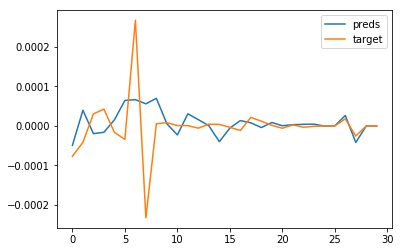

In [211]:
plt.plot(denorm(unravel(preds), outps)[-1, ilat, ilon, 0, :], label='preds')
plt.plot(denorm(unravel(outp_arr), outps)[-1, ilat, ilon, 0, :], label='target')
plt.legend();

So something is off here. Maybe I messed up the input processing. The order of the input variables could be wrong...

## Old stuff

In [69]:
def unravel(x, nlev=30):
    return x.reshape(48, 64, 128, -1, nlev)

In [21]:
preds_de = denorm(preds, outps); preds_de.shape

(48, 64, 128, 2, 30)

In [22]:
out_de = denorm(outp_arr, outps)

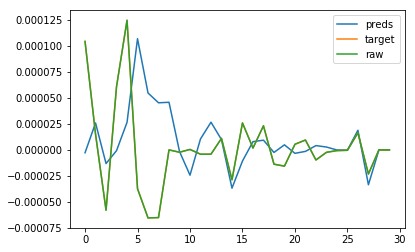

In [63]:
plt.plot(preds_de[4, 30, 60, 0, :], label='preds')
plt.plot(out_de[4, 30, 60, 0, :], label='target')
plt.plot(aqua['TPHYSTND_NORAD'][4, ::-1, 30, 60], label='raw')
plt.legend();

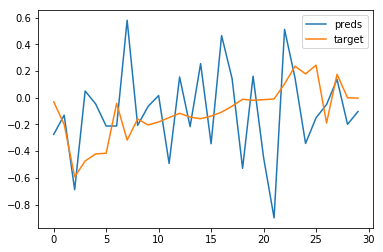

In [68]:
plt.plot(preds[0, 0, :, 0], label='preds')
plt.plot(outp_arr[0, 0, :, 0], label='target')
plt.legend();

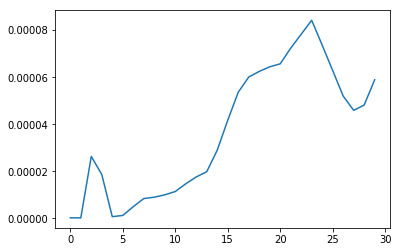

In [77]:
plt.plot(std['TPHYSTND_NORAD'][:, 0, 0])

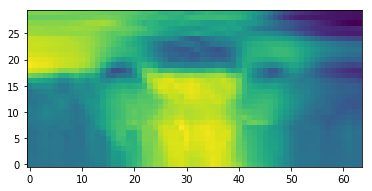

In [83]:
plt.imshow(
    unravel(inp_arr)[-1, :, 38, 0, :].T,
    origin='lower')

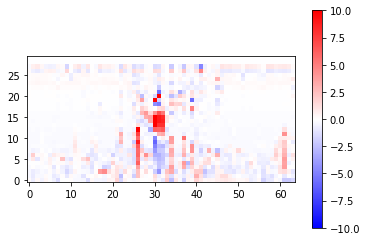

In [84]:
plt.imshow(
    unravel(outp_arr)[-1, :, 38, 0, :].T, 
    origin='lower', cmap='bwr', vmin=-10, vmax=10)
plt.colorbar()

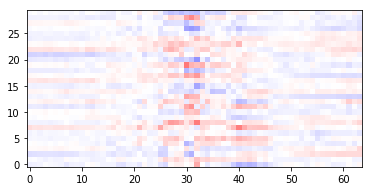

In [85]:
plt.imshow(
    unravel(preds)[-1, :, 38, 0, :].T, 
    origin='lower', cmap='bwr', vmin=-5, vmax=5)

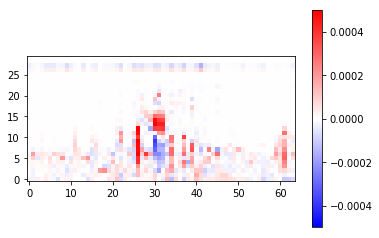

In [86]:
plt.imshow(out_de[-1, :, 38, 0, :].T, origin='lower', cmap='bwr', vmin=-5e-4, vmax=5e-4)
plt.colorbar()

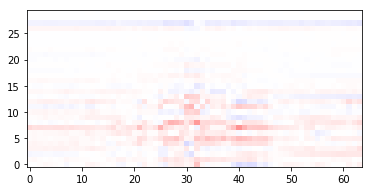

In [87]:
plt.imshow(preds_de[-1, :, 38, 0, :].T, origin='lower', cmap='bwr', vmin=-5e-4, vmax=5e-4)

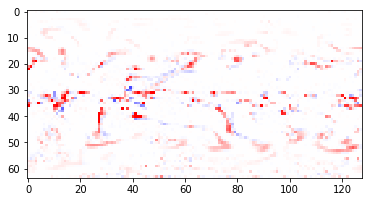

In [88]:
plt.imshow(out_de[-1, :, :, 0, 10], cmap='bwr', vmin=-5e-4, vmax=5e-4)

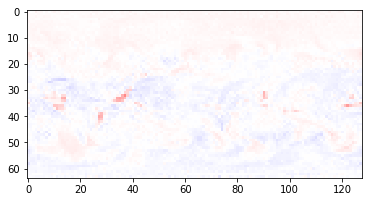

In [89]:
plt.imshow(preds_de[-1, :, :, 0, 10], cmap='bwr', vmin=-5e-4, vmax=5e-4)